# import libraries

In [16]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Subset

from sklearn.model_selection import train_test_split
import sklearn.metrics as skm

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import torchvision
import torchvision.transforms as T
from torchsummary import summary

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

C:\Users\ayxan\AppData\Local\Temp\ipykernel_13252\1963766096.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# import data and split train/devol/test

In [17]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.RandomHorizontalFlip(p=.5),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=False, transform=transform)
devtest  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=False, transform=transform)

category=trainset.classes

# split the devtest into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
devset  = Subset(devtest,randidx[:6000]) # Subset for devset
testset = Subset(devtest,randidx[6000:]) # Subset for test

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=len(devset))
test_loader  = DataLoader(testset, batch_size=len(testset))

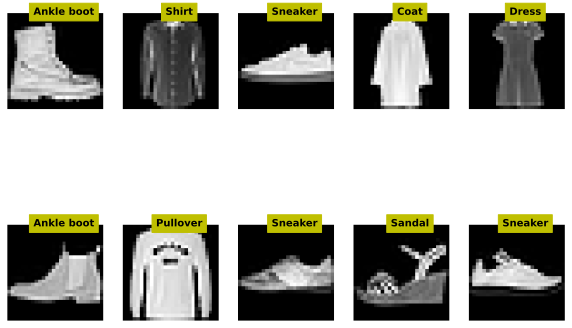

In [35]:
dat,lab=next(iter(test_loader))

fig,axs = plt.subplots(2,5,figsize=(10,7))
for ax in axs.flatten():
    index=np.random.randint(dat.data.shape[0])
    img=dat.data[index].permute(1,2,0)
    img=img/2 + .5
    ax.imshow(img,cmap='gray')
    
    label=category[lab[index]]
    ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
    ax.axis('off')
plt.show()

# cnn model

In [24]:
def createModel(printSize=False):
    class Model(nn.Module):
        def __init__(self,printSize):
            super().__init__()
            
            self.print=printSize
            inChan=1
            firChan=15
            secChan=45
            thirChan=180
            theLastSize=3
            
            self.conv1=nn.Conv2d(inChan,firChan,3,1,1)
            self.bNorm1=nn.BatchNorm2d(firChan)
            
            self.conv2=nn.Conv2d(firChan,secChan,3,1,1)
            self.bNorm2=nn.BatchNorm2d(secChan)
            
            self.conv3=nn.Conv2d(secChan,thirChan,3,1,1)
            self.bNorm3=nn.BatchNorm2d(thirChan)
            
            self.expectedSize=thirChan*theLastSize*theLastSize
            
            self.fc1=nn.Linear(self.expectedSize,300)
            self.fc2=nn.Linear(300,50)
            self.out=nn.Linear(50,10)
           
        def forward(self,x):
            if self.print: print(f'input : {list(x.shape)}')
                
            x=F.max_pool2d( self.conv1(x), 3, 2, 1)
            x=F.leaky_relu( self.bNorm1(x) )
            if self.print: print(f' first cnn layer: {list(x.shape)}' )
                
            x=F.max_pool2d( self.conv2(x), 3, 2, 1)
            x=F.leaky_relu( self.bNorm2(x))
            if self.print: print(f' second cnn layer: {list(x.shape)}' )
                
            x=F.max_pool2d( self.conv3(x), 3, 3, 1)
            x=F.leaky_relu( self.bNorm3(x) )
            if self.print: print(f' third cnn layer: {list(x.shape)}' )
                
            x=x.view(-1, int(self.expectedSize))
            if self.print: print(f' Vectorized: {list(x.shape)}' )
                
            x=F.leaky_relu( self.fc1(x) )
            if self.print: print(f' first ffn layer: {list(x.shape)}' )
                
            x=F.leaky_relu( self.fc2(x) )
            if self.print: print(f' second ffn layer: {list(x.shape)}' )
                
            x=self.out(x)
            if self.print: print(f' output layer: {list(x.shape)}' )
            return x
        
    cnn=Model(printSize)
    lossfun=nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(cnn.parameters(),lr=.001)
    return cnn,lossfun,optimizer

In [25]:
cnn,lossfun,optimizer=createModel(True)
dat,lab=next(iter(dev_loader))
yHat=cnn(dat)

input : [6000, 1, 28, 28]
 first cnn layer: [6000, 15, 14, 14]
 second cnn layer: [6000, 45, 7, 7]
 third cnn layer: [6000, 180, 3, 3]
 Vectorized: [6000, 1620]
 first ffn layer: [6000, 300]
 second ffn layer: [6000, 50]
 output layer: [6000, 10]


# train model

In [27]:
device=torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(device)

cuda:0


In [28]:
def trainModel(Numepoch=10):
    cnn,lossfun,optimizer = createModel(False)
    
    trainLoss=torch.zeros(Numepoch)
    devolLoss=torch.zeros(Numepoch)
    trainErr=[]
    devolErr=[]
    trainAcc=[]
    devolAcc=[]
    cnn.to(device)
    
    nWeights=0
    for pname,weight in cnn.named_parameters():
        if 'bias' not in pname:
            nWeights=nWeights+weight.numel()
    
    for epoch in range(Numepoch):
        batchLoss=[]
        batchErr=[]
        batchAcc=[]
        cnn.train()
        
        for dat,lab in train_loader:
            dat=dat.to(device)
            lab=lab.to(device)
            
            yHat=cnn(dat)
            loss=lossfun(yHat,lab)
            
            #l1 reguluzation
            L1_term=torch.tensor(0.,requires_grad=True)
            for pname,weight in cnn.named_parameters():
                if 'bias' not in pname:
                    L1_term=L1_term + torch.sum(torch.abs(weight))
            
            loss=loss+ 0.001*L1_term/nWeights
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchLoss.append(loss.item())
            
            lab=lab.cpu()
            yHat=yHat.cpu()
            match=(torch.argmax(yHat,axis=1)!=lab).float()
            batchErr.append(100*torch.mean(match).item())
            match=(torch.argmax(yHat,axis=1)==lab).float()
            batchAcc.append(100*torch.mean(match).item())
        
        trainLoss[epoch]=np.mean(batchLoss)
        trainErr.append(np.mean(batchErr))
        trainAcc.append(np.mean(batchAcc))
        
        batchLoss=[]
        batchErr=[]
        batchAcc=[]
        
        cnn.eval()
        
        for dat,lab in dev_loader:
            dat=dat.to(device)
            lab=lab.to(device)
            
            if torch.no_grad():
                yHat=cnn(dat)
                loss=lossfun(yHat,lab)
                        
            batchLoss.append(loss.item())
            
            lab=lab.cpu()
            yHat=yHat.cpu()
            match=(torch.argmax(yHat,axis=1)!=lab).float()
            batchErr.append(100*torch.mean(match).item())
            match=(torch.argmax(yHat,axis=1)==lab).float()
            batchAcc.append(100*torch.mean(match).item())
        
        devolLoss[epoch]=np.mean(batchLoss)
        devolErr.append(np.mean(batchErr))
        devolAcc.append(np.mean(batchAcc))
            
    return  cnn,trainLoss,trainErr,trainAcc,devolLoss,devolErr,devolAcc

In [ ]:
cnn,trainLoss,trainErr,trainAcc,devolLoss,devolErr,devolAcc=trainModel(30)
fig,ax=plt.subplots(1,3,figsize=(16,5))
ax[0].plot(trainLoss,'ro-',label='Train')
ax[0].plot(devolLoss,'go-',label='Devol')
ax[0].set_xlabel('Epoch')
ax[0].set_title(f'train loss:{trainLoss[-1]:.3f}, devol loss:{devolLoss[-1]:.3f}')
ax[0].legend()

ax[1].plot(trainErr,'ro-',label='Train')
ax[1].plot(devolErr,'go-',label='Devol')
ax[1].set_xlabel('Epoch')
ax[1].set_title(f'train Err:{trainErr[-1]:.3f}, devol Err:{devolErr[-1]:.3f}')
ax[1].legend()

ax[2].plot(trainAcc,'ro-',label='Train')
ax[2].plot(devolAcc,'go-',label='Devol')
ax[2].set_xlabel('Epoch')
ax[2].set_title(f'train Acc:{trainAcc[-1]:.3f}, devol Err:{devolAcc[-1]:.3f}')
ax[2].legend()

# model testing

In [31]:
dat,lab=next(iter(test_loader))
dat=dat.to(device)
cnn.to(device)
yHat=cnn(dat)

yHat=yHat.cpu()
dat=dat.cpu()
argmax=torch.argmax(yHat,axis=1)
match=(argmax==lab).float()
accuracy=100*torch.mean(match).item()
accuracy

92.5499975681305

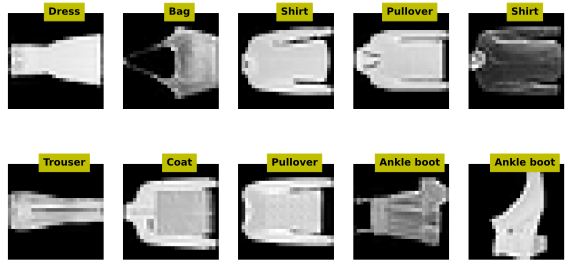

In [39]:
fig,axs=plt.subplots(2,5,figsize=(10,5))
for i,ax in enumerate(axs.flatten()):
    pixel=np.random.randint(dat.data.shape[0])    
    pic=dat.data[pixel].permute(2,1,0)
    pic = pic/2 + .5
    
    pred=category[argmax[pixel]]
    ax.imshow(pic,cmap='gray')
    ax.text(16,0,pred,ha='center',fontweight='bold',color='k',backgroundcolor='y')
    
    ax.axis('off')
plt.show()

# confusion matrix

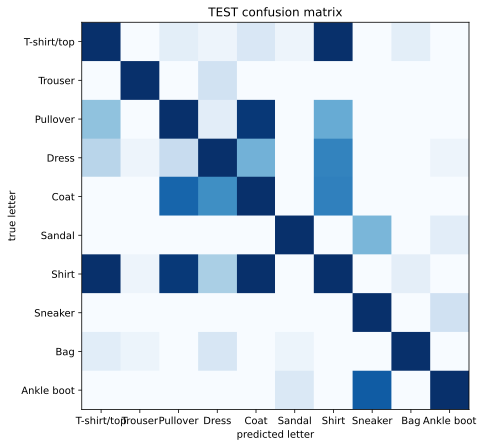

In [40]:
fig=plt.figure(figsize=(7,7))
ConMat=skm.confusion_matrix(lab,argmax,normalize='true')
plt.imshow(ConMat,'Blues',vmax=.05)
plt.xticks(range(10),category)
plt.yticks(range(10),category)
plt.title('TEST confusion matrix')
plt.ylabel('true letter')
plt.xlabel('predicted letter')
plt.show()